In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [3]:
SEASON = '22'
set_seed(int(SEASON))

## Download HKJC odds

In [15]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [16]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [17]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [18]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [19]:
matches_json = json.loads(response.text)['matches']

In [20]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [41]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20230603SATFB2110', '2023-Jun-03', '22:00:00', 'FA Cup [EFA]', 'Manchester City', 'Manchester Utd', 'true', '9.5', '1.76', '1.94', 'false', '10.5', '2.20', '1.59', 'false', '11.5', '2.82', '1.37', 'false', '13.5', '4.75', '1.14', 'false', '14.5', '5.80', '1.09']
['20230603SATFB2288', '2023-Jun-03', '22:00:00', 'Russian Premier [RPL]', 'CSKA Moscow', 'Rostov', 'true', '8.5', '1.73', '1.98', 'false', '12.5', '5.30', '1.11', 'false', '9.5', '2.20', '1.59']
['20230603SATFB2292', '2023-Jun-03', '22:00:00', 'Russian Premier [RPL]', 'Akhmat Grozny', 'FK Krasnodar', 'true', '9.5', '1.97', '1.74', 'false', '10.5', '2.55', '1.45', 'false', '12.5', '4.55', '1.15']
['20230603SATFB2287', '2023-Jun-03', '22:00:00', 'Russian Premier [RPL]', 'FC Nizhny Novgorod', 'Khimki', 'true', '8.5', '1.89', '1.81', 'false', '11.5', '4.55', '1.15', 'false', '9.5', '2.48', '1.47']
['20230603SATFB2293', '2023-Jun-03', '22:00:00', 'Russian Premier [RPL]', 'FC Orenburg', 'Dinamo Moscow', 'true', '10.5', '1.85', '1.8

In [42]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [43]:
odds = [o for o in odds if len(o) == 18]

In [44]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [45]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [46]:
odds

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE_0,CHL_LINE_0,CHL_H_0,CHL_L_0,MAINLINE_1,CHL_LINE_1,CHL_H_1,CHL_L_1,MAINLINE_2,CHL_LINE_2,CHL_H_2,CHL_L_2
0,20230603SATFB2288,2023-Jun-03,22:00:00,Russian Premier [RPL],CSKA Moscow,Rostov,true,8.5,1.73,1.98,false,12.5,5.30,1.11,false,9.5,2.20,1.59
1,20230603SATFB2292,2023-Jun-03,22:00:00,Russian Premier [RPL],Akhmat Grozny,FK Krasnodar,true,9.5,1.97,1.74,false,10.5,2.55,1.45,false,12.5,4.55,1.15
2,20230603SATFB2287,2023-Jun-03,22:00:00,Russian Premier [RPL],FC Nizhny Novgorod,Khimki,true,8.5,1.89,1.81,false,11.5,4.55,1.15,false,9.5,2.48,1.47
3,20230603SATFB2293,2023-Jun-03,22:00:00,Russian Premier [RPL],FC Orenburg,Dinamo Moscow,true,10.5,1.85,1.85,false,11.5,2.30,1.54,false,14.5,5.10,1.12
4,20230603SATFB2296,2023-Jun-03,22:00:00,Russian Premier [RPL],Krylya Sovetov Samara,Spartak Moscow,true,9.5,1.81,1.89,false,10.5,2.29,1.55,false,13.5,5.30,1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,20230605MONFB2232,2023-Jun-05,03:00:00,Italian Division 1 [ISA],Udinese,Juventus,true,9.5,1.80,1.90,false,10.5,2.27,1.56,false,13.5,5.10,1.12
66,20230605MONFB2275,2023-Jun-05,08:30:00,Argentine Division 1 [APL],Lanus,Atletico Tucuman,true,9.5,2.15,1.62,false,10.5,2.80,1.38,false,12.5,4.90,1.13
67,20230605MONFB2266,2023-Jun-05,09:00:00,Central and North American Cup [CNC],Los Angeles FC,Club Leon,true,10.5,1.92,1.78,false,11.5,2.45,1.48,false,13.5,4.05,1.19
68,20230606TUEFB2250,2023-Jun-06,01:00:00,Swedish Division 1 [SAL],Varbergs,Hacken,true,10.5,1.86,1.84,false,11.5,2.35,1.52,false,14.5,5.10,1.12


In [47]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [48]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [49]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [50]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2', 'UCL', 'UEC', 'UEF']
map_league = map_league[map_league.Div.isin(div)].reset_index(drop=True)

In [51]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [52]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [53]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [54]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [55]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [56]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [57]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [58]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [59]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [60]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [61]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [62]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [63]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [64]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [65]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,SUNFB2227,SUNFB2225,SUNFB2224,MONFB2226,MONFB2230
Date,2023-06-04 00:00:00,2023-06-04 00:00:00,2023-06-04 00:00:00,2023-06-05 00:00:00,2023-06-05 00:00:00
Time,00:30:00,03:00:00,03:00:00,00:30:00,03:00:00
LeagueJC,Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA],Italian Division 1 [ISA]
HomeTeamJC,AC Torino,Empoli,Cremonese,Napoli,Roma
AwayTeamJC,Inter Milan,Lazio,Salernitana,Sampdoria,Spezia
MAINLINE_0,true,true,true,true,true
CHL_LINE_0,9.5,9.5,9.5,9.5,9.5
CHL_H_0,2.08,1.95,1.86,1.85,1.78
CHL_L_0,1.66,1.75,1.84,1.85,1.92


## Load model

In [66]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [67]:
to = load_pandas('models/to.pkl')

In [68]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [69]:
odds = odds.dropna(how='any')

In [70]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [71]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
0,I1,Torino,Inter,10.6,5.2,19.8,7.4,11.0,14.4,9.6,13.8
1,I1,Empoli,Lazio,13.2,5.8,8.6,3.0,12.2,12.8,15.2,14.6
2,I1,Cremonese,Salernitana,13.2,2.0,8.8,3.6,8.6,8.0,18.6,16.4
3,I1,Napoli,Sampdoria,16.2,6.8,7.6,3.4,16.6,8.2,8.6,16.6
4,I1,Roma,Spezia,16.6,7.2,12.2,6.4,13.8,13.4,9.8,10.2
5,I1,Milan,Verona,16.6,7.0,10.6,4.4,14.4,10.8,9.0,15.0
6,I1,Atalanta,Monza,17.4,8.2,9.2,2.6,14.6,10.4,8.6,14.6
7,I1,Lecce,Bologna,16.8,7.2,14.0,3.0,12.6,15.4,13.8,10.6
8,I1,Udinese,Juventus,13.0,4.2,11.0,6.2,9.4,16.6,13.0,14.2
9,F1,Paris SG,Clermont,15.6,4.4,11.6,3.0,17.0,8.2,11.6,12.8


In [72]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [73]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [74]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [75]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [76]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [77]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [78]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [79]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,SUNFB2227,2023-06-04,00:30:00,Italian Division 1 [ISA],AC Torino,Inter Milan,True,9.5,2.08,1.66,0.067303,0.057491,4.964182,5.571870,-49.977787,-0.097558
1,SUNFB2225,2023-06-04,03:00:00,Italian Division 1 [ISA],Empoli,Lazio,True,9.5,1.95,1.75,0.066748,0.071167,5.147499,5.049929,-47.997051,-0.108817
2,SUNFB2224,2023-06-04,03:00:00,Italian Division 1 [ISA],Cremonese,Salernitana,True,9.5,1.86,1.84,0.075148,0.076629,4.961553,4.879626,-46.817993,-0.121392
3,MONFB2226,2023-06-05,00:30:00,Italian Division 1 [ISA],Napoli,Sampdoria,True,9.5,1.85,1.85,0.061656,0.156101,7.603687,2.657198,-48.640430,-0.177952
4,MONFB2230,2023-06-05,03:00:00,Italian Division 1 [ISA],Roma,Spezia,True,9.5,1.78,1.92,0.067893,0.126711,5.971803,3.834069,-46.237370,-0.162254


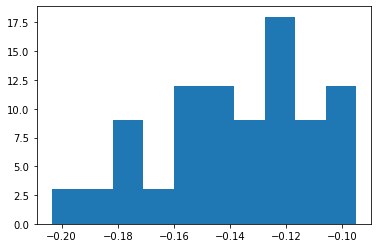

In [80]:
odds['corr'].hist(grid=False);

In [81]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [82]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [83]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [84]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [85]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [86]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [87]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.3, '$$$', np.where(
            odds['kelly']>0.2, '$$', np.where(
                odds['kelly']>0.1, '$', None))), 
    None
)

In [88]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [89]:
odds[odds.bet.notna() & odds.selected.notna()]

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,MONFB2229,2023-06-05,03:00:00,Italian Division 1 [ISA],Lecce,Bologna,True,9.5,2.00,1.72,0.663783,0.336217,0.327565,High,$$$
4,SUNFB2178,2023-06-04,03:00:00,French Division 1 [FFL],Auxerre,Lens,True,8.5,1.64,2.12,0.703933,0.296067,0.241329,High,$$
5,MONFB2212,2023-06-05,03:00:00,Spanish Division 1 [SFL],Valladolid,Getafe,True,9.5,1.97,1.74,0.331179,0.668821,0.221283,Low,$$
6,SUNFB2227,2023-06-04,00:30:00,Italian Division 1 [ISA],AC Torino,Inter Milan,True,9.5,2.08,1.66,0.590330,0.409670,0.211005,High,$$
7,MONFB2228,2023-06-05,03:00:00,Italian Division 1 [ISA],AC Milan,Verona,True,9.5,1.86,1.84,0.626778,0.373221,0.192800,High,$
16,MONFB2218,2023-06-05,00:30:00,Spanish Division 1 [SFL],Mallorca,Vallecano,True,9.5,1.95,1.75,0.383085,0.616915,0.106135,Low,$
19,MONFB2215,2023-06-05,03:00:00,Spanish Division 1 [SFL],Betis,Valencia,True,10.5,2.08,1.66,0.356477,0.643523,0.103405,Low,$


In [90]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,MONFB2229,2023-06-05,03:00:00,Italian Division 1 [ISA],Lecce,Bologna,True,9.5,2.00,1.72,0.663783,0.336217,0.327565,High,$$$
1,MONFB2229,2023-06-05,03:00:00,Italian Division 1 [ISA],Lecce,Bologna,False,10.5,2.60,1.43,0.555173,0.444827,0.277157,High,None
2,MONFB2212,2023-06-05,03:00:00,Spanish Division 1 [SFL],Valladolid,Getafe,False,10.5,2.48,1.47,0.234188,0.765812,0.267538,Low,None
3,MONFB2212,2023-06-05,03:00:00,Spanish Division 1 [SFL],Valladolid,Getafe,False,12.5,4.40,1.16,0.101844,0.898156,0.261630,Low,None
4,SUNFB2178,2023-06-04,03:00:00,French Division 1 [FFL],Auxerre,Lens,True,8.5,1.64,2.12,0.703933,0.296067,0.241329,High,$$
5,MONFB2212,2023-06-05,03:00:00,Spanish Division 1 [SFL],Valladolid,Getafe,True,9.5,1.97,1.74,0.331179,0.668821,0.221283,Low,$$
6,SUNFB2227,2023-06-04,00:30:00,Italian Division 1 [ISA],AC Torino,Inter Milan,True,9.5,2.08,1.66,0.590330,0.409670,0.211005,High,$$
7,MONFB2228,2023-06-05,03:00:00,Italian Division 1 [ISA],AC Milan,Verona,True,9.5,1.86,1.84,0.626778,0.373221,0.192800,High,$
8,SUNFB2178,2023-06-04,03:00:00,French Division 1 [FFL],Auxerre,Lens,False,10.5,2.68,1.41,0.480920,0.519080,0.171945,High,None
9,SUNFB2227,2023-06-04,00:30:00,Italian Division 1 [ISA],AC Torino,Inter Milan,False,10.5,2.70,1.40,0.477066,0.522934,0.169458,High,None


In [91]:
odds[odds.MAINLINE].to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)